In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nasa-cmaps/CMaps/RUL_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/Damage Propagation Modeling.pdf
/kaggle/input/nasa-cmaps/CMaps/readme.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/x.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD001.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD001.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/RUL_FD002.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/test_FD003.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/Damage Propagation Modeling.pdf
/kaggle/input/nasa-cmaps/cmaps/CMaps/readme.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/train_FD003.txt
/kaggle/input/nasa-cmaps/cmaps/CM

About this Dataset
Description
Prognostics and health management is an important topic in industry for predicting state of assets to avoid downtime and failures. This data set is the Kaggle version of the very well known public data set for asset degradation modeling from NASA. It includes Run-to-Failure simulated data from turbo fan jet engines.

Engine degradation simulation was carried out using C-MAPSS. Four different were sets simulated under different combinations of operational conditions and fault modes. Records several sensor channels to characterize fault evolution. The data set was provided by the Prognostics CoE at NASA Ames.

Prediction Goal
In this dataset the goal is to predict the remaining useful life (RUL) of each engine in the test dataset. RUL is equivalent of number of flights remained for the engine after the last datapoint in the test dataset.

Data Set Organization
Data Set: FD001

Train trjectories: 100

Test trajectories: 100

Conditions: ONE (Sea Level)

Fault Modes: ONE (HPC Degradation)

Data Set: FD002

Train trjectories: 260

Test trajectories: 259

Conditions: SIX

Fault Modes: ONE (HPC Degradation)

Data Set: FD003

Train trjectories: 100

Test trajectories: 100

Conditions: ONE (Sea Level)

Fault Modes: TWO (HPC Degradation, Fan Degradation)

Data Set: FD004

Train trjectories: 248

Test trajectories: 249

Conditions: SIX

Fault Modes: TWO (HPC Degradation, Fan Degradation)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import QuantileTransformer , PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from keras import optimizers
from keras.models import Sequential
from keras.layers import TimeDistributed, Flatten
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_squared_error

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

## Conduct Dataframe

In [3]:
train_file = "../input/nasa-cmaps/CMaps/test_FD001.txt" 
test_file = "../input/nasa-cmaps/CMaps/test_FD001.txt"
RUL_file = "../input/nasa-cmaps/CMaps/RUL_FD001.txt"

data = pd.read_csv(train_file,sep=" ",header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


In [4]:

data.drop(columns=[26,27],inplace=True)
columns = ["Section-{}".format(i)  for i in range(26)]
data.columns = columns

data.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


#### Dataset statistics  for each parameter

In [5]:
data.describe()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
count,13096.000000,13096.000000,13096.000000,13096.000000,13096.0,1.309600e+04,13096.000000,13096.000000,13096.000000,1.309600e+04,...,13096.000000,13096.000000,13096.000000,13096.000000,1.309600e+04,13096.000000,13096.0,13096.0,13096.000000,13096.000000
mean,51.543907,76.836515,-0.000011,0.000004,100.0,5.186700e+02,642.475088,1588.099204,1404.735362,1.462000e+01,...,521.747724,2388.071025,8138.947817,8.425844,3.000000e-02,392.571625,2388.0,100.0,38.892502,23.335743
std,28.289423,53.057749,0.002203,0.000294,0.0,6.014263e-11,0.400899,5.003274,6.688309,2.671743e-12,...,0.559627,0.056934,10.188605,0.029009,8.823140e-15,1.233577,0.0,0.0,0.141681,0.084120
min,1.000000,1.000000,-0.008200,-0.000600,100.0,5.186700e+02,641.130000,1569.040000,1384.390000,1.462000e+01,...,519.380000,2387.890000,8108.500000,8.332800,3.000000e-02,389.000000,2388.0,100.0,38.310000,22.935400
25%,28.000000,33.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.197500,1584.600000,1399.950000,1.462000e+01,...,521.380000,2388.030000,8132.310000,8.405600,3.000000e-02,392.000000,2388.0,100.0,38.800000,23.281600
50%,52.000000,69.000000,0.000000,0.000000,100.0,5.186700e+02,642.460000,1587.990000,1404.440000,1.462000e+01,...,521.780000,2388.070000,8138.390000,8.424900,3.000000e-02,393.000000,2388.0,100.0,38.900000,23.339200
75%,76.000000,113.000000,0.001500,0.000300,100.0,5.186700e+02,642.740000,1591.362500,1409.050000,1.462000e+01,...,522.150000,2388.110000,8144.360000,8.444300,3.000000e-02,393.000000,2388.0,100.0,38.990000,23.393600
max,100.000000,303.000000,0.007800,0.000700,100.0,5.186700e+02,644.300000,1607.550000,1433.360000,1.462000e+01,...,523.760000,2388.320000,8220.480000,8.541400,3.000000e-02,397.000000,2388.0,100.0,39.410000,23.641900


In [6]:
# Names 
MachineID_name = ["Section-0"]
RUL_name = ["Section-1"]
OS_name = ["Section-{}".format(i) for i in range(2,5)]
Sensor_name = ["Section-{}".format(i) for i in range(5,26)]

# Data in pandas DataFrame
MachineID_data = data[MachineID_name]
RUL_data = data[RUL_name]
OS_data = data[OS_name]
Sensor_data = data[Sensor_name]

# Data in pandas Series
MachineID_series = data["Section-0"]
RUL_series = data["Section-1"]

In [7]:
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
print("Max Life >> ",max(max_cycles))
print("Mean Life >> ",np.mean(max_cycles))
print("Min Life >> ",min(max_cycles))

Max Life >>  303
Mean Life >>  130.96
Min Life >>  31


In [8]:
data.drop(columns=["Section-0","Section-4", "Section-5", "Section-9", "Section-10",  "Section-14","Section-20","Section-22", "Section-23"] , inplace=True)
data.head()

,Section-1,Section-2,Section-3,Section-6,Section-7,Section-8,Section-11,Section-12,Section-13,Section-15,Section-16,Section-17,Section-18,Section-19,Section-21,Section-24,Section-25
0,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735
1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916
2,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166
3,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737
4,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130


## Normalized data

In [9]:

gen = MinMaxScaler(feature_range=(0, 1))
data = gen.fit_transform(data)
data = pd.DataFrame(data)
data=np.nan_to_num(data)

pt = PowerTransformer()
data = pt.fit_transform(data)
data

array([[-1.7938502 ,  1.04936462,  1.00459956, ..., -0.43585161,
        -0.26636316,  0.42059548],
       [-1.75983242, -1.22056415, -1.03515135, ...,  0.37849296,
         0.89958112,  0.64708667],
       [-1.72609272,  0.14086219,  0.34489676, ...,  0.37849296,
         1.36106153,  0.96601877],
       ...,
       [ 1.83603259, -0.26773967, -1.03515135, ...,  1.88097691,
        -1.83688401, -1.50936271],
       [ 1.84590292, -1.71931856,  0.34489676, ...,  1.88097691,
        -1.5901386 , -0.80455247],
       [ 1.85572407,  0.59502963,  1.00459956, ...,  2.57907106,
        -1.33736328, -1.7132478 ]])

## Train data using LTSM

In [10]:
def RUL_df():
    rul_lst = [j  for i in MachineID_series.unique() for j in np.array(grp.get_group(i)[::-1]["Section-1"])]
    rul_col = pd.DataFrame({"rul":rul_lst})
    return rul_col


X_train = np.array(data)

y_train = np.array(RUL_df()).reshape(-1,1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 


print(X_train.shape,y_train.shape)
X_train

(13096, 17) (13096, 1)


array([[-1.7938502 ,  1.04936462,  1.00459956, ..., -0.43585161,
        -0.26636316,  0.42059548],
       [-1.75983242, -1.22056415, -1.03515135, ...,  0.37849296,
         0.89958112,  0.64708667],
       [-1.72609272,  0.14086219,  0.34489676, ...,  0.37849296,
         1.36106153,  0.96601877],
       ...,
       [ 1.83603259, -0.26773967, -1.03515135, ...,  1.88097691,
        -1.83688401, -1.50936271],
       [ 1.84590292, -1.71931856,  0.34489676, ...,  1.88097691,
        -1.5901386 , -0.80455247],
       [ 1.85572407,  0.59502963,  1.00459956, ...,  2.57907106,
        -1.33736328, -1.7132478 ]])

## Count the number of cycles

In [11]:
#print(max_cycles)
print(sum(max_cycles))
count = 0
for cycle_len in max_cycles:
    for i in range(6):
        y_train[count+i] = 0
    count = count + cycle_len
print(count)

13096
13096


## AR model : using( t(i)... t(1+10) predict t(i+11)

In [12]:
def create_dataset(X, AR=10):
    data = []
    for i in range(len(X)-AR-1):
        data.append(X[i:(i+AR)])
    return np.array(data)


X_train = create_dataset(X_train)
y_train = y_train[11:]

In [13]:
def predict_model(layers):
        #d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        #model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        #model.add(Dropout(d))
        model.add(Dense(16,kernel_initializer='uniform',activation='relu'))        
        model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
        model.compile(loss='mean_squared_error',optimizer='adam')
        return model

In [14]:
model = predict_model([17,5])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 128)            74752     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 125,217
Trainable params: 125,217
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
history = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=100,
    validation_split=0.15,
    verbose=1)

Epoch 1/100
22/22 [==============================] - 3s 118ms/step - loss: 7657.9507 - val_loss: 8719.8242
Epoch 2/100
22/22 [==============================] - 2s 85ms/step - loss: 7514.9575 - val_loss: 8469.4951
Epoch 3/100
22/22 [==============================] - 2s 83ms/step - loss: 7224.2812 - val_loss: 8083.2393
Epoch 4/100
22/22 [==============================] - 2s 82ms/step - loss: 6795.3921 - val_loss: 7555.8242
Epoch 5/100
22/22 [==============================] - 2s 90ms/step - loss: 6249.0586 - val_loss: 6916.7920
Epoch 6/100
22/22 [==============================] - 2s 80ms/step - loss: 5622.4854 - val_loss: 6219.8384
Epoch 7/100
22/22 [==============================] - 2s 81ms/step - loss: 4976.1509 - val_loss: 5515.0811
Epoch 8/100
22/22 [==============================] - 2s 81ms/step - loss: 4355.4805 - val_loss: 4873.9263
Epoch 9/100
22/22 [==============================] - 2s 81ms/step - loss: 3818.0723 - val_loss: 4331.9785
Epoch 10/100
22/22 [=========================

In [16]:
y_train_pred = model.predict(X_train)
print("R-Squared Score ", r2_score(y_train,y_train_pred))


R-Squared Score  0.7992082122330018


**R_square score of the predictive model using LTSM is 0.795**

## Test Dataset

In [17]:
df_test = pd.read_csv(test_file, sep=" ",header=None)
df_test.drop(columns=[26,27],inplace=True)
df_test.columns = columns
df_test.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [18]:
df_rul = pd.read_csv(RUL_file, names=['rul'])
df_rul.head()

,rul
0,112
1,98
2,69
3,82
4,91


In [19]:
RUL_name = ["Section-1"]
RUL_data = df_test[RUL_name]
MachineID_series = df_test["Section-0"]
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
max_cycles[0] = max_cycles[0] - 6

In [20]:
df_test.drop(df_test[["Section-0", "Section-4", "Section-5",  "Section-9", "Section-10",  "Section-14", "Section-20", "Section-22","Section-23"]], axis=1 , inplace=True)
df_test.head()            

,Section-1,Section-2,Section-3,Section-6,Section-7,Section-8,Section-11,Section-12,Section-13,Section-15,Section-16,Section-17,Section-18,Section-19,Section-21,Section-24,Section-25
0,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735
1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916
2,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166
3,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737
4,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130


In [21]:
gen = MinMaxScaler(feature_range=(0, 1))
df_test = gen.fit_transform(df_test)
df_test = pd.DataFrame(df_test)
#df_test = df_test.rolling(20).mean()
pt = PowerTransformer()
df_test = pt.fit_transform(df_test)
df_test=np.nan_to_num(df_test)

In [22]:
X_test = np.array(df_test)

y_test = np.array(df_rul)

print(X_test.shape,y_test.shape)
print(max_cycles)

(13096, 17) (100, 1)
[ 25  49 126 106  98 105 160 166  55 192  83 217 195  46  76 113 165 133
 135 184 148  39 130 186  48  76 140 158 171 143 196 145  50 203 198 126
 121 125  37 133 123 156 172  54 152 146  73  78 303  74 144 189 164 121
 113 136 160 176  94 147 159 232 155 168  71 147  71 187  54 152  68 131
 112 137  88 205 162  72 101 133 213 162  73 172  34 110  56  68 177 146
 234 150 244 133  89  97 134 121  97 198]


## AR model : using( t(i)... t(i+5) predict t(i+6)

In [23]:
def create_dataset(X, look_back=5):
    data = []
    for i in range(len(X)-look_back-1):
        data.append(X[i:(i+look_back)])
    return np.array(data)
X_test = create_dataset(X_test)
print(X_test.shape,y_test.shape)

(13090, 5, 17) (100, 1)


In [24]:
pred = model.predict(X_test)
pred.shape

(13090, 1)

In [25]:
final_pred = []
count = 0
for i in range(100):
    temp = 0
    j = max_cycles[i] 
    while j>0:
        temp = temp + pred[count]
        j=j-1
        count=count+1
    final_pred.append(int(temp/max_cycles[i]))

In [26]:
print(final_pred)

[162, 99, 60, 85, 83, 80, 110, 79, 76, 101, 35, 115, 100, 32, 145, 139, 65, 91, 133, 80, 121, 105, 161, 55, 150, 131, 132, 82, 109, 57, 74, 45, 48, 68, 49, 33, 120, 31, 176, 39, 112, 112, 95, 128, 71, 79, 36, 115, 103, 137, 96, 97, 96, 112, 124, 35, 77, 99, 148, 91, 76, 109, 71, 90, 60, 66, 137, 89, 116, 89, 115, 102, 155, 86, 129, 93, 97, 67, 117, 91, 81, 84, 128, 84, 69, 94, 155, 56, 68, 81, 34, 31, 45, 68, 142, 106, 96, 93, 84, 87]


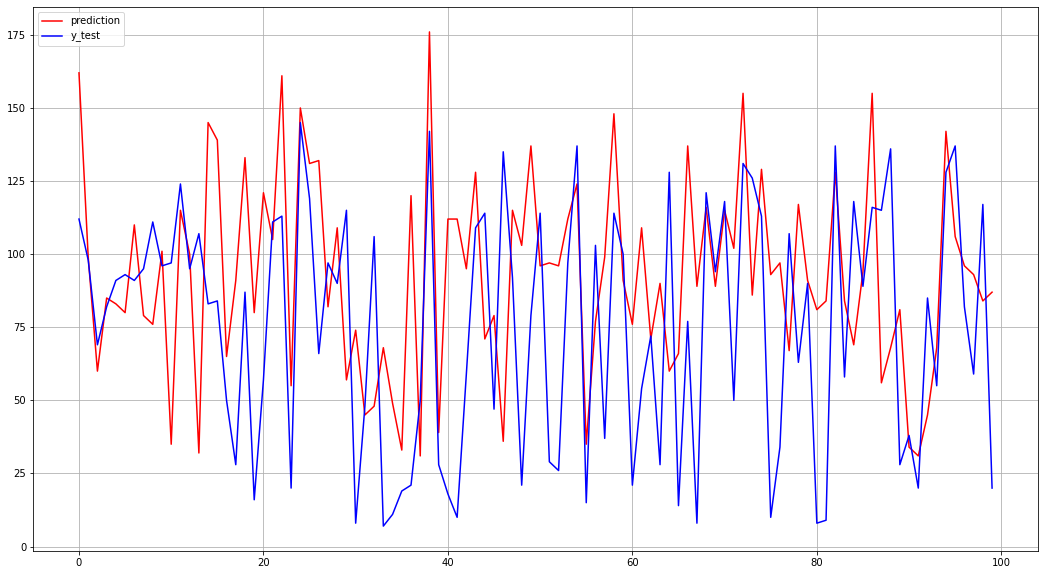

In [27]:
fig = plt.figure(figsize=(18,10))
plt.plot(final_pred,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [28]:
print("mean_squared_error >> ", mean_squared_error(y_test,final_pred))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_test,final_pred)))
print("mean_absolute_error >>",mean_absolute_error(y_test,final_pred))

mean_squared_error >>  2173.12
root_mean_squared_error >>  46.61673519241776
mean_absolute_error >> 38.06
